<center><h1> Lab 2 : GMM </h1></center>


## Done by :Ahmed BEJAOUI

### A few tactical imports and configurations


In [1]:
import math

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.display import HTML
from numpy.linalg import slogdet
from scipy.special import logsumexp
from scipy.stats import multivariate_normal

matplotlib.style.use('ggplot')
# to embed figures in the notebook
%matplotlib inline
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

### Table of content

[1. Question 1](#a)<br>
[2. Question 2](#b)<br>
[3. Question 3.1](#ca)<br>
[4. Question 3.2](#cb)<br>
[5. Question 3.2.a](#cba)<br>
[6. Question 3.2.b](#cbb)<br>
[7. Question 3.2.c](#cbc)<br>

<a id='a'></a>
<div class="alert alert-success">
<strong><center>Question 1: Implement a function for numerically stable computation
of ${\{\gamma_i\}}^N_{n=1}= \frac{\pi_i\mathcal{N}(x,\mu_i,\sigma_i)}{\sum_{j=1}^{K}\pi_j\mathcal{N}(x,\mu_j,\sigma_j)}$</center></strong></div>

 $$\gamma_i(x)=\frac{\pi_i \mathcal{N}(x,\mu_i,\Sigma_i)}{\sum_{j=1}^{K}\pi_j \mathcal{N}(x,\mu_j,\Sigma_j)}$$
 where $\mathcal{N}(x,\mu_j,\Sigma_j)= \frac{1}{\sqrt{(2\pi_j)^n}\sqrt{(|\Sigma_j|)}}e^{-\frac{(x-\mu_j)^T\Sigma_j^{-1}(x-\mu_j)}{2}}$
 <br>
then 
$$\gamma_i(x)=\frac{\pi_i \frac{1}{\sqrt{(2\pi_i)^n}\sqrt{(|\Sigma_i|)}}e^{-\frac{(x-\mu_i)^T\Sigma_i^{-1}(x-\mu_i)}{2}}}{\sum_{k=1}^{K}\pi_k \frac{1}{\sqrt{(2\pi_k)^n}\sqrt{(|\Sigma_k|)}}e^{-\frac{(x-\mu_k)^T\Sigma_k^{-1}(x-\mu_k)}{2}}}$$

In [2]:
def l_i(x,p_i,u_i,sigma_i):
    
    n=x.shape[0]
    log_det=-1/2*np.linalg.slogdet(sigma_i)[1]
    c= -n/2 * np.log( 2 * math.pi )
    log_gaussian= 0.5 * (x - u_i).T.dot(np.linalg.inv(sigma_i)).dot(x - u_i)
    return c+log_det-log_gaussian+np.log(p_i)
#  the slogdet is function that give us a numerically stable way to compute the determinant


def log_gamma(x,i,p,u,sigma):
    K=u.shape[0]
    log_sum_exp=logsumexp( [l_i( x , p[j], u[j], sigma[j] ) for j in range(K)])
    return l_i( x , p[i], u[i], sigma[i] ) - log_sum_exp

<a id='b'></a>

<div class="alert alert-success">
<strong><center>Question 2: Derive the M-Step of the Expectation-Maximization algorithm for this model to find ${π_{1:K}}^{(t+1)}$ ,${μ_{1:K}}^{(t+1)}$ , and ${Σ_{1:K}}^{(t+1)}$ . </center></strong></div>

<div class="alert alert-info">

We have $$p(x_{1:N},z_{1:N}|\mu_{1:K},\Sigma_{1:k},\pi_{1:K})=\Pi_n^{N}\Pi_k^{K}(\pi_k \mathcal{N}(x,\mu_k,\Sigma_k))^\mathbb{1_{z_n=k}}$$
Then $$\log(p(x_{1:N},z_{1:N}|\mu_{1:K},\Sigma_{1:k},\pi_{1:K})) = \sum_n^{N} \sum_k^{K} \mathbb{1_{z_n=k}}( \log(\pi_k)+\log(\mathcal{N}(x,\mu_k,\Sigma_k))$$
We pass the expectation with respect to $p(z|x_{1:n},\mu_{1:K},\Sigma_{1:k},\pi_{1:K})$
we obtain
$\begin{align*} 
L(\mu_{1:K},\Sigma_{1:k},\pi_{1:K}))&=\mathbb{E}_{p(z|x_{1:n},\mu_{1:K},\Sigma_{1:k},\pi_{1:K})}(\log(p(x_{1:N},z_{1:N}|\mu_{1:K},\Sigma_{1:k},\pi_{1:K}))) \\ 
&= \sum_n^{N} \sum_k^{K} \mathbb{E}(\mathbb{1_{z_n=k}})( \log(\pi_k)+\log(\mathcal{N}(x,\mu_k,\Sigma_k))\\
&= \sum_n^{N} \sum_k^{K} \gamma_k(x)( \log(\pi_k)+\log(\mathcal{N}(x,\mu_k,\Sigma_k))\\
\end{align*}$
<br>
in fact  $$\mathbb{E}_{p(z|x_{1:n},\mu_{1:K},\Sigma_{1:k},\pi_{1:K})}(\mathbb{1_{z_n=k}})=\frac{\pi_i \mathcal{N}(x,\mu_i,\Sigma_i)}{\sum_{j=1}^{K}\pi_j \mathcal{N}(x,\mu_j,\Sigma_j)}=\gamma_k(x)$$
we have $$(\mu_{1:K},\Sigma_{1:k},\pi_{1:K})^*=\arg\max_{(\mu_{1:K},\Sigma_{1:k},\pi_{1:K})}L(\mu_{1:K},\Sigma_{1:k},\pi_{1:K}))$$
Notice: to facilitate the computation we will work on sample gaussian
First,we determine $\lambda$with the Lagrangian multiplier:
$$g_1(x)=\sum_n^{N} \sum_k^{K} \mathbb{1_{z_n=k}}\log(\Pi_k)-\lambda (\sum_k^{K}\Pi_k-1)$$
$\triangledown g_1(x)=0 $ induce$ \lambda=\sum_n^{N} \sum_k^{K}\mathbb{1_{z_n=k}}=N$
Then $$\Pi_{k}=\frac{\sum_n^{N}\mathbb{1_{z_n=k}}}{N}$$
We pass the expectation with respect to $p(z|x_{1:n},\mu_{1:K},\Sigma_{1:k},\pi_{1:K})$
we obtain:
$$\Pi_{k}^*=\frac{\sum_n^{N}\gamma_k(x_n)}{N}$$
after that we determine $\mu_k$

$\begin{align*} 
\triangledown_{\mu_k}\log(p(x,z|\mu_{1:K},\Sigma_{1:k},\pi_{1:K})&=\sum_n^{N} \mathbb{1_{z_n=k}}\triangledown_{\mu_k}\log(p(x_n|\mu_{K},\Sigma_{k})\\ 
&=-\sum_n^{N} \mathbb{1_{z_n=k}}\frac{x_n-u_k}{\sigma^2}\\
\end{align*}$
<br>
We pass the expectation with respect to $p(z|x_{1:n},\mu_{1:K},\Sigma_{1:k},\pi_{1:K})$
we obtain:
$$\mathbb{E}(\triangledown_{\mu_k}\log(p(x,z|\mu_{1:K},\Sigma_{1:k},\pi_{1:K}))= -\sum_n^{N} \mathbb{E}(\mathbb{1_{z_n=k}})\frac{x_n-u_k}{\sigma^2}=0$$
then
$$\mu_{k}^*=\sum_n^{N} \gamma_k(x_n)\frac{x_n}{\sum_i^{N} \gamma_k(x_n)}$$

<br>
finally we search $\sigma_k$
<br>

$\begin{align*} 
\triangledown_{\sigma_k}\log(p(x,z|\mu_{1:K},\Sigma_{1:k},\pi_{1:K})&=\sum_n^{N} \sum_k^{K} \mathbb{1_{z_n=k}}\triangledown_{\sigma_k}\log(p(x_n|\mu_{K},\Sigma_{k})\\ 
&=\sum_n^{N} \sum_k^{K}  \mathbb{1_{z_n=k}}(\frac{N}{2*\sigma^2}+\frac{||x_n-u_k||^2}{2*\sigma^4})\\
\end{align*}$
<br>
We pass the expectation with respect to $p(z|x_{1:n},\mu_{1:K},\Sigma_{1:k},\pi_{1:K})$
we obtain:
$\begin{align*} 
\triangledown_{\sigma_k}\log(p(x,z|\mu_{1:K},\Sigma_{1:k},\pi_{1:K}))&=\sum_n^{N} \sum_k^{K}  \mathbb{E}(\mathbb{1_{z_n=k}})(\frac{N}{2*\sigma^2}+\frac{||x_n-u_k||^2}{2*\sigma^4})\\
&=\sum_n^{N} \gamma_k(x_n)(\frac{N}{2*\sigma^2}+\frac{||x_n-u_k||^2}{2*\sigma^4})\\&=0
\end{align*}$
<br>
$$\frac{N}{\sigma^2}\sum_n^{N}  \gamma_k(x_n)=\frac{1}{\sigma^4}\sum_n^{N} \gamma_k(x_n)||x_n-u_k||^2$$

$${(\sigma^2)^*}=\frac{1}{\sum_n^{N}  \gamma_k(x_n)}\sum_n^{N} \gamma_k(x_n)||x_n-u_k||^2$$
to conclude we have:
- $$(\Pi_{k}^*)^{t+1}=\frac{\sum_n^{N}\mathbb{1_{z_n=k}}}{N}$$
- $$(\mu_{k}^*)^{t+1}=\sum_n^{N} \gamma_k(x_n)\frac{x_n}{\sum_i^{N} \gamma_k(x_n)}$$
- $$(\sigma^2)^{t+1}=\frac{1}{\sum_n^{N}  \gamma_k(x_n)}\sum_n^{N} \gamma_k(x_n)||x_n-u_k||^2$$
</div>


In [3]:
def P_xn(xn,p,u,sigma):
    K = u.shape[0]
    l = np.array( [l_i( xn , p[i], u[i], sigma[i] ) for i in range( K ) ] )
    exp_l=np.exp(l)
    return np.sum(exp_l)


<a id='c'></a>
<div class="alert alert-success">
<strong><center>Question 3 </center></strong></div>

#### Initialisation of the true value of  $\pi_{1:K}^{(0)}$ , $\mu_{1:K}^{(0)}$ and  $\Sigma_{1:K}^{(0)}$

In [4]:
p=np.array([0.3,0.2,0.5])
u=np.array([[0,0],[1,2],[2,0]])
sigma = np.array([[[1.00, -0.25], [ -0.25, 0.50]],[ [0.50, 0.25],[0.25, 0.50]], [[0.50, -0.25], [-0.25, 1]]])


<a id='ca'></a>
<div class="alert alert-success">
    <div class="alert alert-success">
<strong><center>3.1. Generate a dataset ${\{x_n\}}^N_{n=1}$ by using the model definition (set N = 1000). Visualize the dataset.</center></strong></div>

</div>

###  Generate a dataset

In [5]:
def generate_x(u,sigma,p,N=1000,K=3):
    """
    Input:
    u: mean vector
    sigma= vector of  K matrices of variance 
    p; prior probability
    N: number of point
    K= number of cluster
    
    Output: generate N point accordind to the Gaussian Mixture Model
    """
    return np.sum([(np.random.multivariate_normal(u[k],sigma[k],N))* p[k] for k in range(K)],axis=0)

X=generate_x(u,sigma,p,N=1000)
    
X

array([[1.85128344, 0.19319312],
       [0.87250437, 0.38024104],
       [1.90400075, 0.07551669],
       ...,
       [0.49646822, 0.39745419],
       [0.73041014, 1.64037413],
       [1.34580777, 0.78663459]])

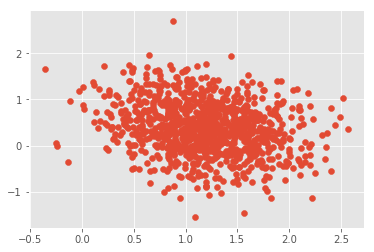

In [6]:
plt.scatter(X[:,0],X[:,1])

<a id='cb'></a>
<div class="alert alert-success">
<strong><center>3.2 Implement the EM algorithm for GMMs (be careful about numerical stability!)</center></strong>
</div>

### Define some functions to plot the contour and the distribution

In [7]:
def point_in_cluster(X, cluster,K=3):
    for i in range(K):
        Y=X[cluster==i]
        print (Y.shape[0])

In [8]:
def ellipse_line(A, mu=np.array([0,0]), col='b'):

    N = 36
    th = np.arange(0, 2*np.pi+np.pi/N, np.pi/N)
    X = np.array([np.cos(th),np.sin(th)])

    Y = np.dot(A, X)
    ln = plt.Line2D(mu[0]+Y[0,:],mu[1]+Y[1,:],markeredgecolor='k', linewidth=1, color=col)
    return ln



In [9]:
def plot_dist(X,u_l,sigma_l,p_l,cluster,ite,plot_each=10,verbose=False):
    """
    Input:
    X: data point
    u_l: mean vector
    sigma_l= vector of  K matrices of variance
    cluster: vetor of corresponding cluster for points X
    ite: N° iteration
    plot_each; plot figure for each plot_each
    verbose= True : do the printing
    
    Output: plot figure
    """
    if verbose==True:
        print("----------- itera"+str(ite+1)+"-----------------------")
        print("p_l")
        print(p_l)
        print("u_l")
        print(u_l)
        print("sigma_l")
        print(sigma_l)
        point_in_cluster(X, cluster,K=3)
    if ite % plot_each==0:
        fig = plt.figure(figsize=(10,10))
        ax0 = fig.add_subplot(111)
        ax0.scatter(X[:,0],X[:,1],c=cluster)
        ax0.set_title('distribution at iteration :'+str(ite+1))
    
        color=['m','b','y']
        ax = plt.gca()
        for i in range(3):
            A = np.linalg.cholesky(sigma_l[i])
            m = u_l[i]

            plt.scatter(m[0],m[1],marker='4',c=color[i],s=500)
            ln = ellipse_line(3*A, m, color[i])
            ax.add_line(ln)


### Implementation of EM algorithm

In [10]:
def EM_alg(X,p_,u_,sigma_,n_iter,plot_each=10,verbose=False):
    """
    Input:
    X: data point
    p_: prior vector
    u_l: mean vector
    sigma_l= vector of  K matrices of variance
    cluster: vetor of corresponding cluster for points X
    n_ite: number of iterations
    plot_each; plot figure for each plot_each
    verbose= True : do the printing
    
    Output:
    p: final prior probability 
    u: final mean vector
    sigma: final vector of  K matrices of variance
    log:  the log_likelyhood vector
    """
#   ----------Initialisation------------------
    K=p.shape[0]
    N = X.shape[0]
    log=[]
# ---------------------------------------------------------------------------

    for t in range(n_iter):
        
#   ----------Initialisation for each iteration------------------
        p_l=[]
        u_l=[]
        sigma_l=[]
        cluster=[]
        gamma=np.array([])
# ---------------------------------------------------------------------------

        
        for k in range (K):
# -----------------------------M-step---------------------------------------
#         calcul gamma
            log_gamma_k=np.array([ log_gamma(X[i],k,p_,u_,sigma_) for i in range(N) ])
            gamma_k=np.exp(log_gamma_k)
# ---------------------------------------------------------------------------


# -----------------------------u-step-------------------------------------
#         calcul u
            sum_gamma_k=np.sum(gamma_k)
            u_k=1. / sum_gamma_k * np.sum([gamma_k[n]*X[n] for n in range(N)],axis=0)


#         calcul sigma
            sigma_k = np.sum(np.array([gamma_k[n] * (X[n] - u_k).reshape((u_k.shape[0],1)).dot((X[n] - u_k).reshape((u_k.shape[0],1)).T) for n in range(N)]),axis = 0) / sum_gamma_k           
            
#         calcul pi 
            p_k = sum_gamma_k / N
            
            p_l.append(p_k)
            u_l.append(u_k)
            sigma_l.append(sigma_k)
        
#       updating the value of p,u, sigma at each iteration                        
        p_ = np.array(p_l)
        u_ = np.array(u_l)
        sigma_ = np.array(sigma_l)
# ---------------------------------------------------------------------------
        
#       clustering assign each point to its correspanding 
        cluster=np.array([])

        for i in range(N):
            temp=np.array([np.exp(l_i(X[i],p_[k],u_[k],sigma_[k]))/ p_[k] for k in range(K)])
            cluster=np.append(cluster,np.argmax(temp))
# ---------------------------------------------------------------------------

        
#         compute the log likely hood
        log_t=np.sum(np.array([[logsumexp( [l_i( X[n] , p_[j], u_[j], sigma_[j] ) for j in range(K)])]for n in range(N)]))
        log.append(log_t)
# ---------------------------------------------------------------------------

        
#         plot the points and the contours of the estimated Gaussians.
        plot_dist(X,u_,sigma_,p_,cluster,t,plot_each,verbose)       
# ---------------------------------------------------------------------------

    return p, u, sigma,log
        
        
        
        

<a id='cba'></a>

<div class="alert alert-success">
<strong><center>3.a Run the EM algorithm after randomly initializing the parameter estimates ${π_{1:K}}^{(0)}$ ,${μ_{1:K}}^{(0)}$ , and ${Σ_{1:K}}^{(0)}$ . Visualize the intermediate results by plotting the contours of the estimated Gaussians.

### Random intialisation

In [11]:
def generate_matrices(K=3,d=2):
    p_=np.random.rand(K)
    u_=np.random.rand(K,d)*4
    A = np.random.rand(K,d,d)
    return p_ / np.sum(p_) ,u_ ,np.array([A[i,:,:].dot(A[i,:,:].T) for i in range(K)])



p_init,u_init,sigma_init=generate_matrices()


In [12]:
p_in=np.array([0.25,0.35,0.4])
u_in=np.array([[0,1.5],[1.5,2],[1,2]])
sigma_in = np.array([[[1.00, -0.2], [ -0.3, 0.58]],[ [0.2, 0.25],[0.25, 0.70]], [[0.50, -0.15], [-0.2, 1]]])

----------- itera1-----------------------
p_l
[0.2855671 0.3834994 0.3309335]
u_l
[[ 0.81301702  0.59547945]
 [ 1.1847096   0.71925963]
 [ 1.49359811 -0.15573379]]
sigma_l
[[[ 0.14218686 -0.01726125]
  [-0.01726125  0.33314416]]

 [[ 0.16556271  0.01500772]
  [ 0.01500772  0.0833676 ]]

 [[ 0.14870163  0.04324927]
  [ 0.04324927  0.14344489]]]
306
350
344
----------- itera2-----------------------
p_l
[0.3045545  0.36358603 0.33185948]
u_l
[[ 0.82506523  0.59713209]
 [ 1.20617428  0.68771892]
 [ 1.47942904 -0.11317082]]
sigma_l
[[[ 0.14111697 -0.02647969]
  [-0.02647969  0.36200045]]

 [[ 0.1714479   0.01562763]
  [ 0.01562763  0.09976466]]

 [[ 0.15258346  0.02863314]
  [ 0.02863314  0.15348274]]]
307
342
351
----------- itera3-----------------------
p_l
[0.3127833  0.35471364 0.33250306]
u_l
[[ 0.83204422  0.59935339]
 [ 1.21812993  0.66777851]
 [ 1.46901249 -0.09019596]]
sigma_l
[[[ 0.1418772  -0.03141837]
  [-0.03141837  0.37243751]]

 [[ 0.17534877  0.0168    ]
  [ 0.0168      0.11

----------- itera24-----------------------
p_l
[0.34505782 0.32664483 0.32829735]
u_l
[[ 0.88632991  0.61746298]
 [ 1.25273202  0.57566656]
 [ 1.41869705 -0.02056516]]
sigma_l
[[[ 0.1546249  -0.04046139]
  [-0.04046139  0.34628532]]

 [[ 0.20158194  0.01204633]
  [ 0.01204633  0.15984362]]

 [[ 0.16731336 -0.00486787]
  [-0.00486787  0.21510319]]]
341
306
353
----------- itera25-----------------------
p_l
[0.3456977  0.32599344 0.32830886]
u_l
[[ 0.88753247  0.6186181 ]
 [ 1.25293214  0.5736438 ]
 [ 1.4179404  -0.01983353]]
sigma_l
[[[ 0.15497228 -0.0404613 ]
  [-0.0404613   0.34496611]]

 [[ 0.20199701  0.01205297]
  [ 0.01205297  0.16055699]]

 [[ 0.16754247 -0.00491865]
  [-0.00491865  0.21616753]]]
342
305
353
----------- itera26-----------------------
p_l
[0.34631224 0.32535429 0.32833348]
u_l
[[ 0.88868702  0.61980113]
 [ 1.2530937   0.57166174]
 [ 1.41723407 -0.01915695]]
sigma_l
[[[ 0.15530292 -0.04045847]
  [-0.04045847  0.34367611]]

 [[ 0.20239166  0.01209088]
  [ 0.01209088

----------- itera47-----------------------
p_l
[0.35533673 0.31383068 0.33083259]
u_l
[[ 0.90766218  0.64939388]
 [ 1.24844454  0.53497542]
 [ 1.40996409 -0.01299072]]
sigma_l
[[[ 0.15957347 -0.04052146]
  [-0.04052146  0.3202338 ]]

 [[ 0.20976289  0.01840894]
  [ 0.01840894  0.16801651]]

 [[ 0.17068358 -0.00353029]
  [-0.00353029  0.22977897]]]
344
299
357
----------- itera48-----------------------
p_l
[0.35563248 0.3133469  0.33102062]
u_l
[[ 0.90851202  0.65098189]
 [ 1.24782123  0.53334473]
 [ 1.40985382 -0.01294413]]
sigma_l
[[[ 0.15969268 -0.04056503]
  [-0.04056503  0.31918752]]

 [[ 0.21019158  0.01891681]
  [ 0.01891681  0.16811676]]

 [[ 0.17075491 -0.00340744]
  [-0.00340744  0.23011021]]]
342
301
357
----------- itera49-----------------------
p_l
[0.35591864 0.31286731 0.33121406]
u_l
[[ 0.90937006  0.65258347]
 [ 1.24715766  0.53171883]
 [ 1.40975712 -0.01291193]]
sigma_l
[[[ 0.15980739 -0.04061523]
  [-0.04061523  0.31814089]]

 [[ 0.21063453  0.01943945]
  [ 0.01943945

----------- itera70-----------------------
p_l
[0.36033816 0.30316071 0.33650113]
u_l
[[ 0.92962188  0.68767294]
 [ 1.2257364   0.49956115]
 [ 1.40925123 -0.01454577]]
sigma_l
[[[ 1.62045668e-01 -4.30613100e-02]
  [-4.30613100e-02  2.95858329e-01]]

 [[ 2.22201684e-01  3.20606009e-02]
  [ 3.20606009e-02  1.67563614e-01]]

 [[ 1.71344610e-01 -2.80537518e-04]
  [-2.80537518e-04  2.33947769e-01]]]
284
363
353
----------- itera71-----------------------
p_l
[0.3605134  0.30268255 0.33680406]
u_l
[[ 0.93060438  0.68926915]
 [ 1.22459387  0.49823413]
 [ 1.40921535 -0.01469724]]
sigma_l
[[[ 1.62187370e-01 -4.31974176e-02]
  [-4.31974176e-02  2.94828157e-01]]

 [[ 2.22725440e-01  3.26234689e-02]
  [ 3.26234689e-02  1.67427878e-01]]

 [[ 1.71357149e-01 -1.44272919e-04]
  [-1.44272919e-04  2.33986984e-01]]]
283
365
352
----------- itera72-----------------------
p_l
[0.36068914 0.30220075 0.33711011]
u_l
[[ 0.93157335  0.69084184]
 [ 1.22347057  0.49693878]
 [ 1.40917123 -0.01485264]]
sigma_l
[[[ 

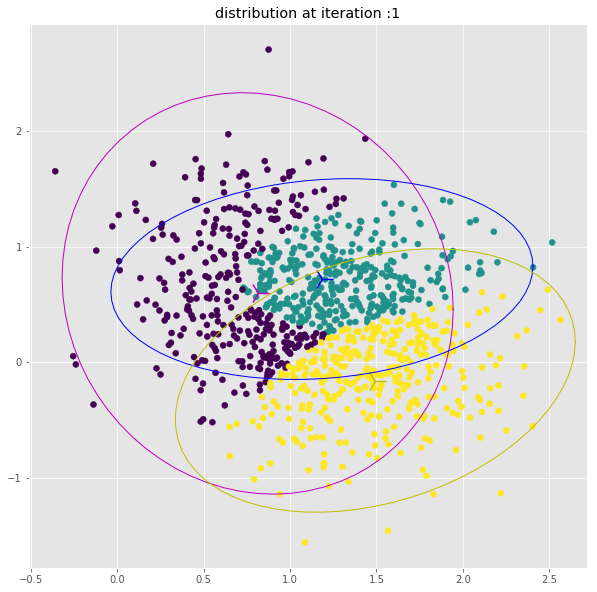

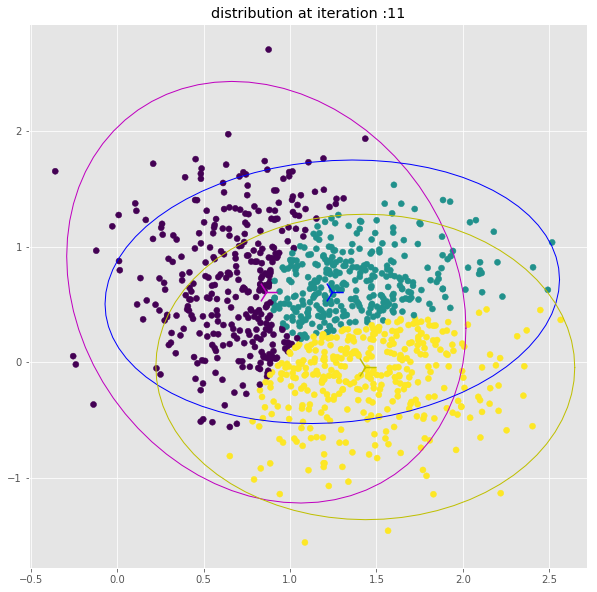

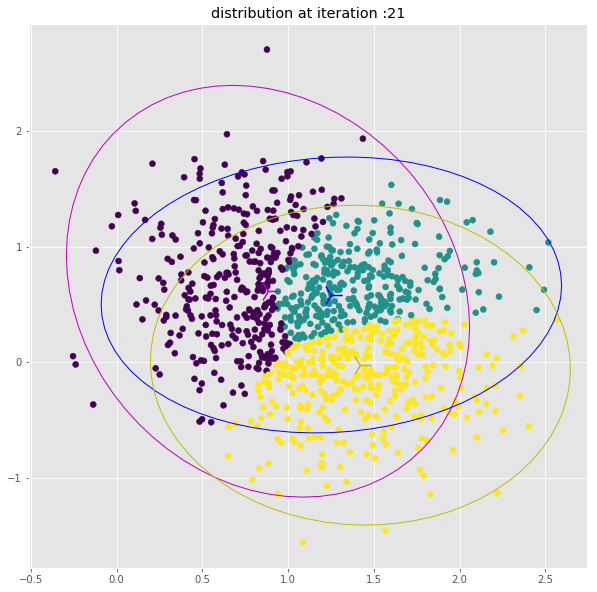

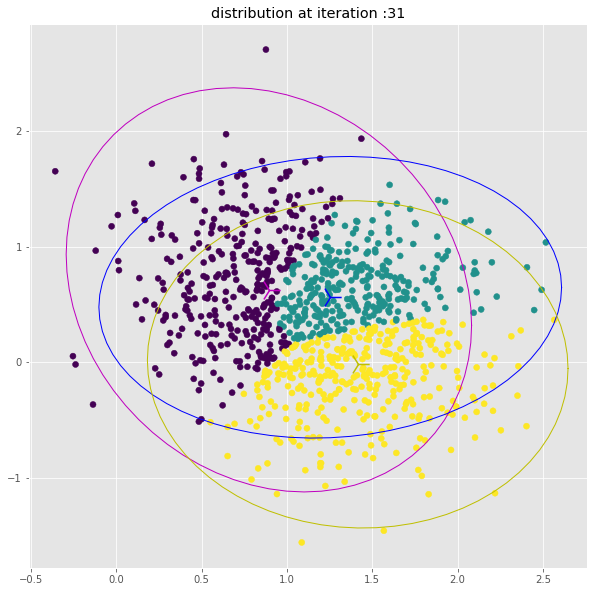

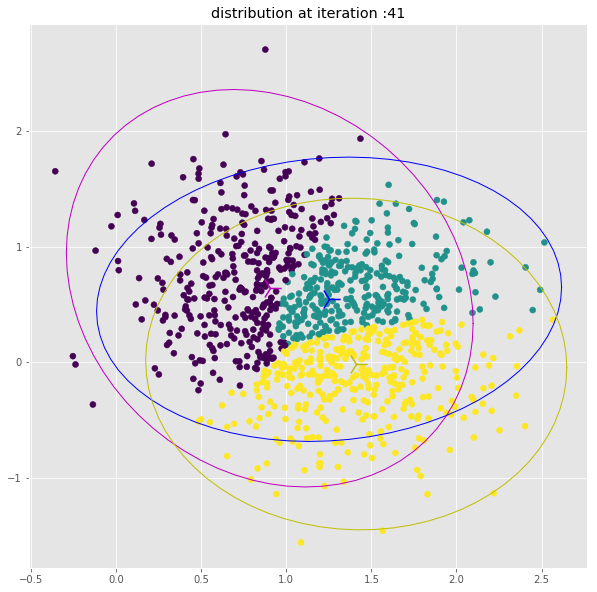

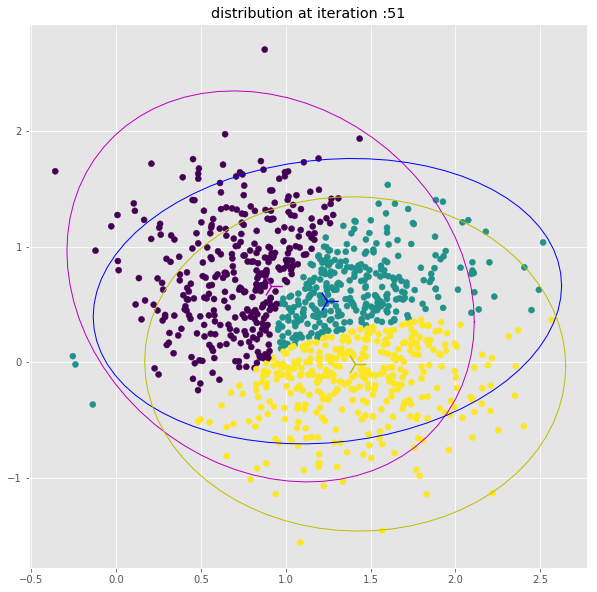

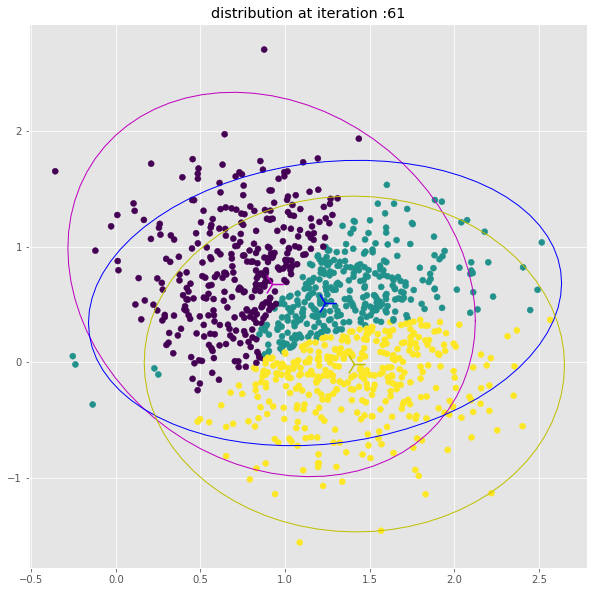

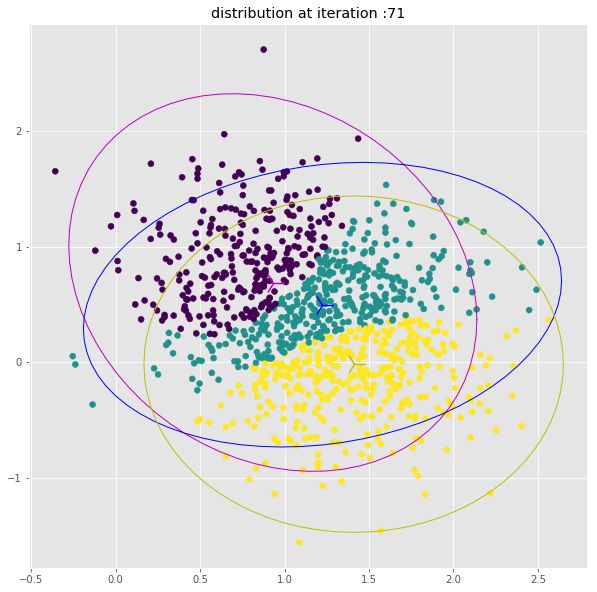

In [14]:
p_init,u_init,sigma_init=generate_matrices()
p_final, u_final, sigma_final,log=EM_alg(X,p_init,u_init,sigma_init,n_iter=80,verbose=True)

<div class="alert alert-info">
<center><strong> Comment: </strong></center>
    
when we set the paramater Verbose=True, we can see the evolution of the number of points in each cluster, and the new value of ${π_{1:K}}^{(0)}$ ,${μ_{1:K}}^{(0)}$ , and ${Σ_{1:K}}^{(0)}$ at each iteration  


<a id='cbb'></a>

<div class="alert alert-success">
<strong><center>b) While running the EM algorithm, compute the log-likelihood. Plot the log-likelihood vs iterations (be careful about numerical stability!).<strong><center>

In [15]:
def plot_log_likelyhood(log_):
    plt.plot(log_)
    plt.xlabel("number of iteration")
    plt.ylabel("log_likelyhood value")
    plt.title("log_likelyhood")

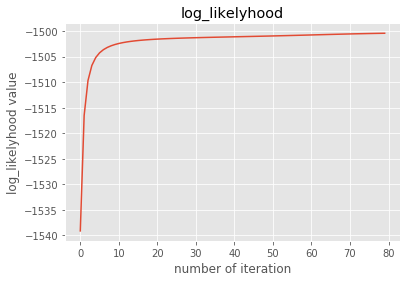

In [16]:
plot_log_likelyhood(log)

<a id='cbc'></a>
<div class="alert alert-success">
<center><strong>3.c) Run the EM algorithm with different initializations for $\pi_{1:K}^{(0)}$ , $\mu_{1:K}^{(0)}$ and  $\Sigma_{1:K}^{(0)}$.  How sensitive is the algorithm for different initial values?</strong></center> 
</div>

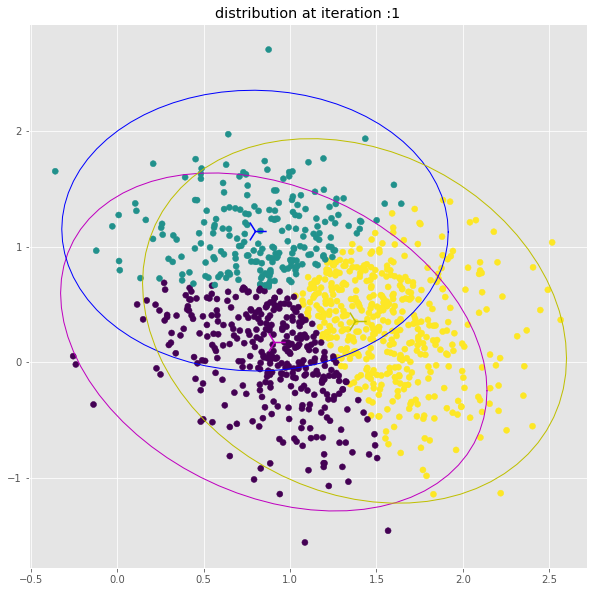

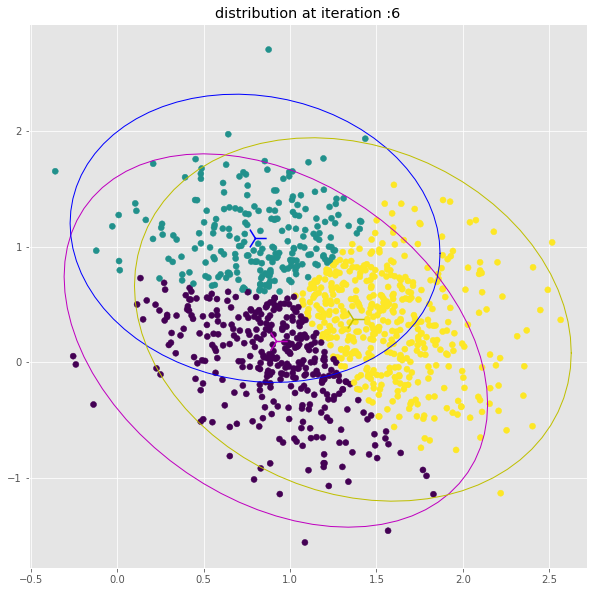

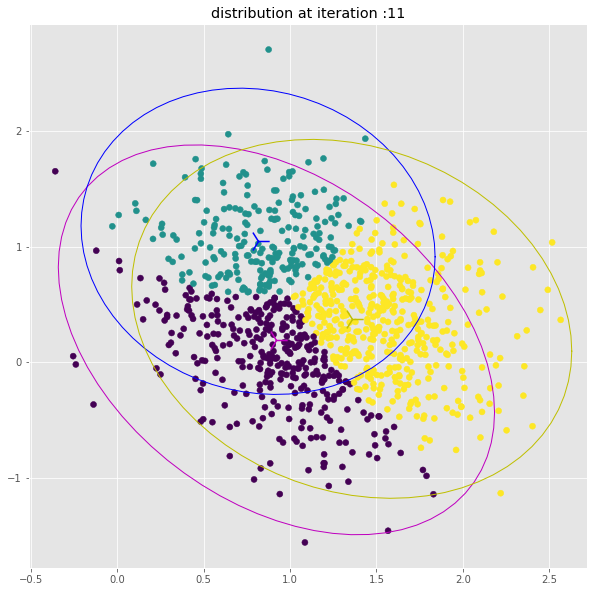

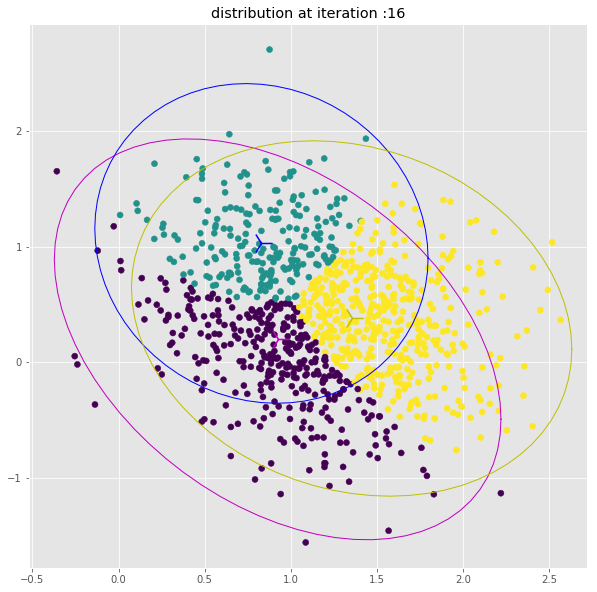

In [17]:
p_final, u_final, sigma_final,log=EM_alg(X,p,u,sigma,n_iter=20,plot_each=5)

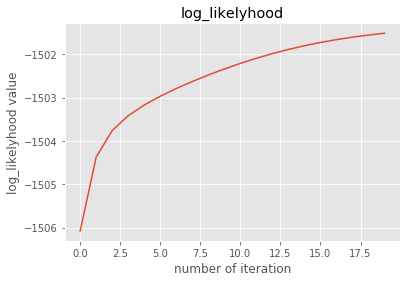

In [18]:
plot_log_likelyhood(log)

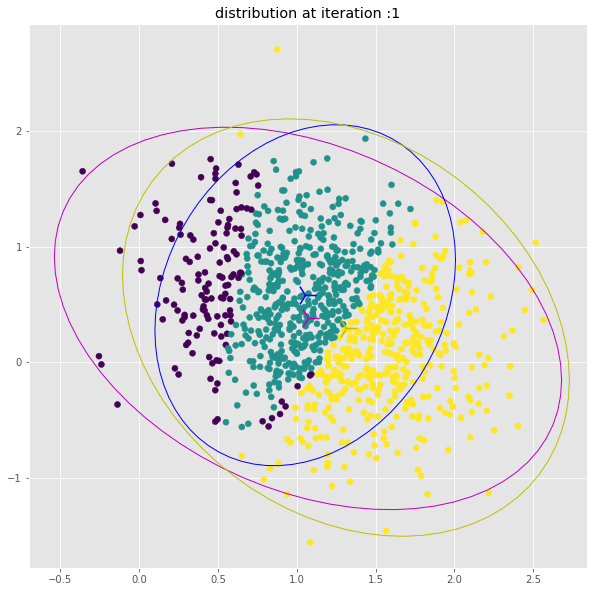

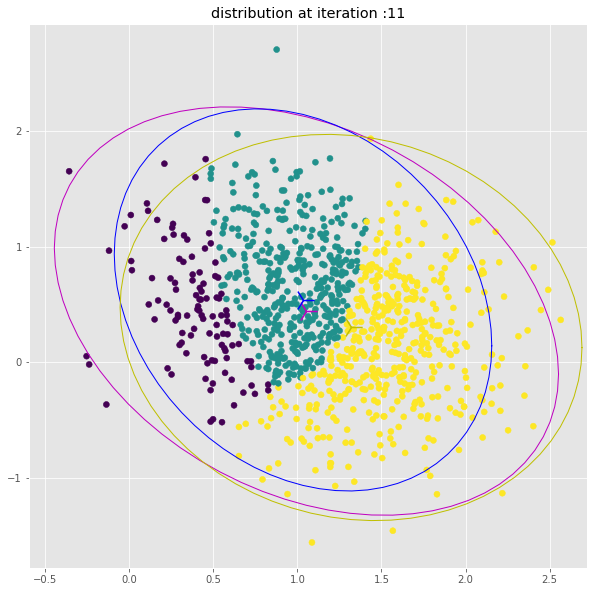

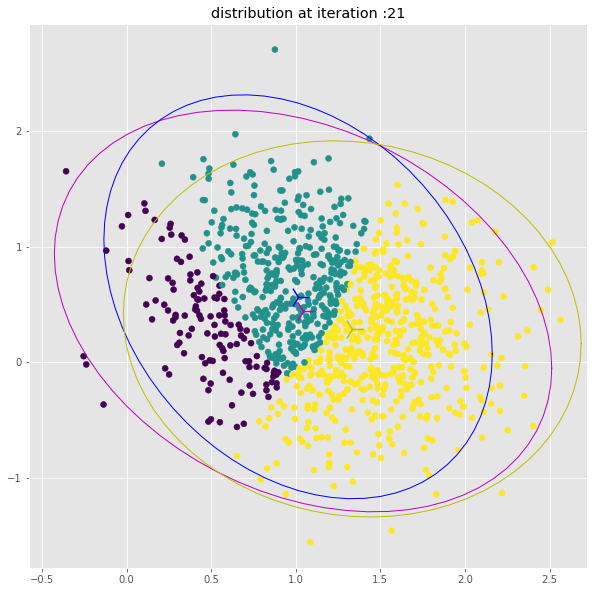

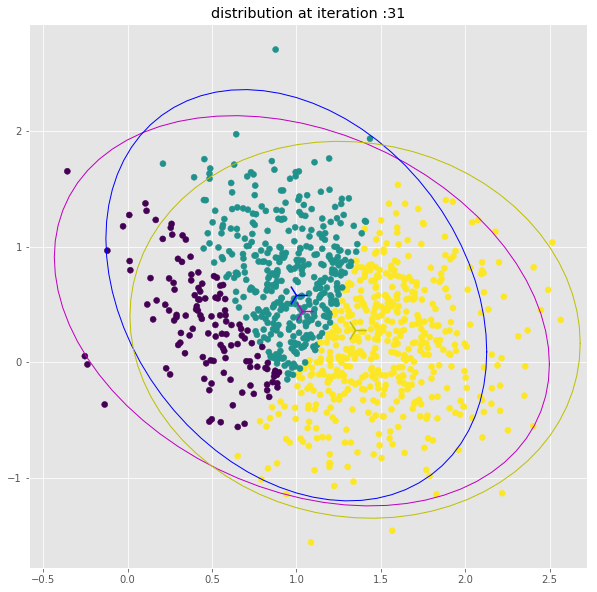

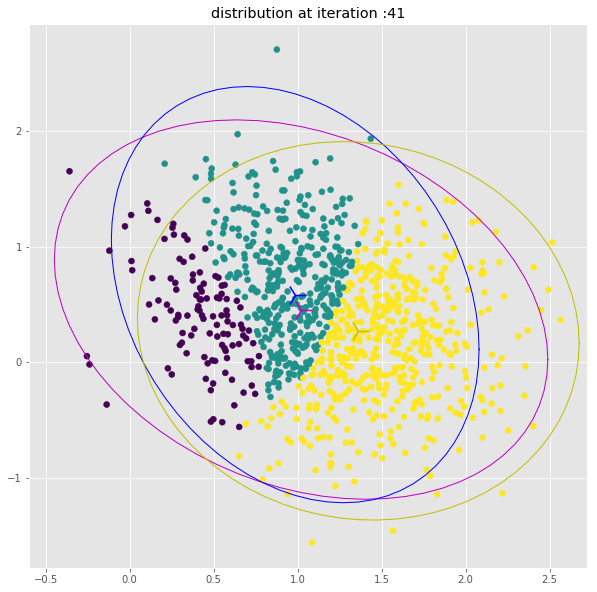

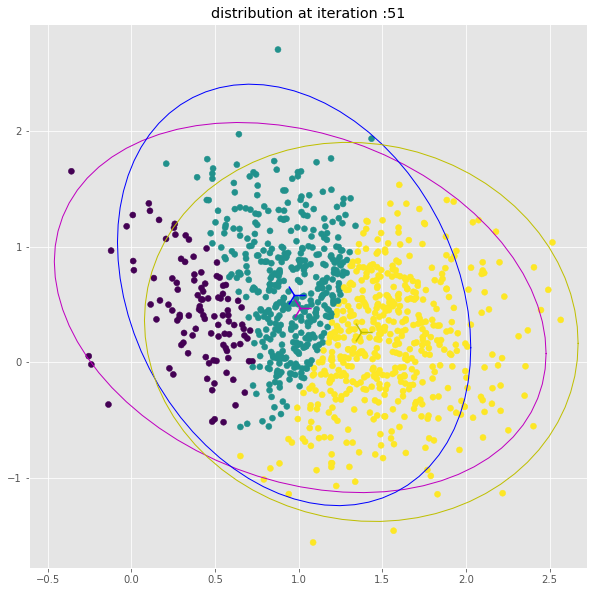

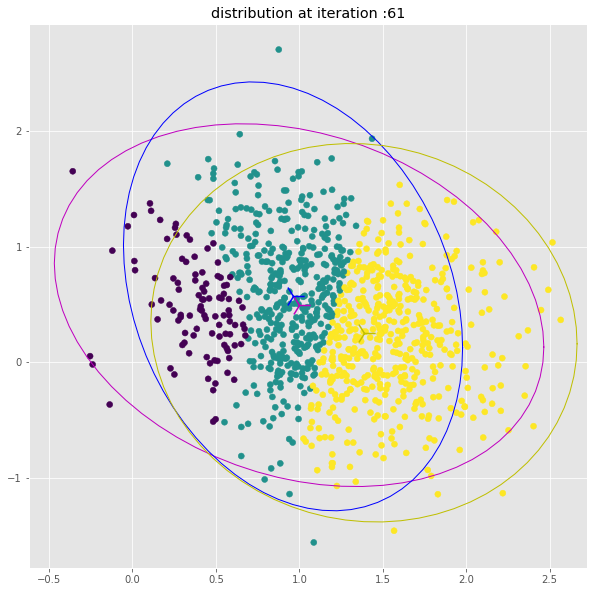

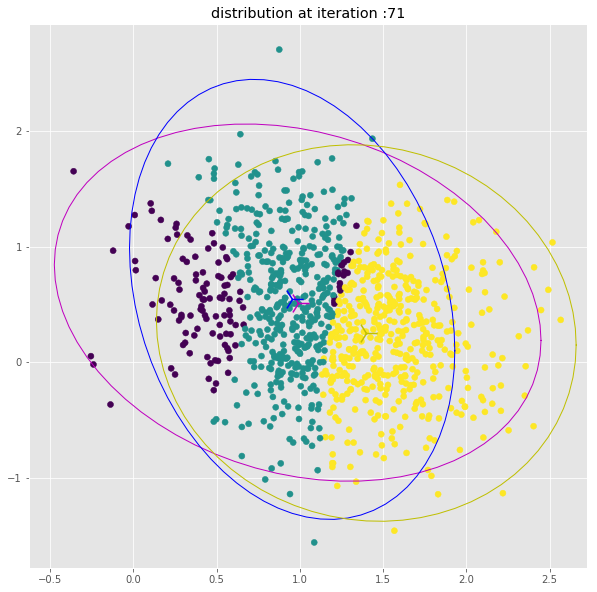

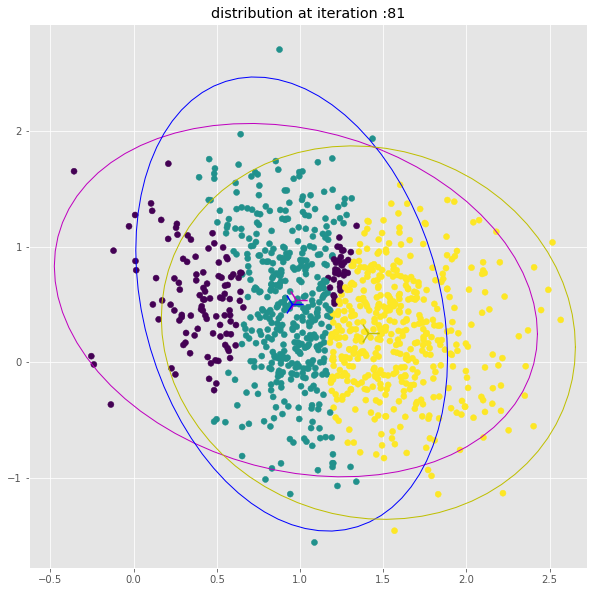

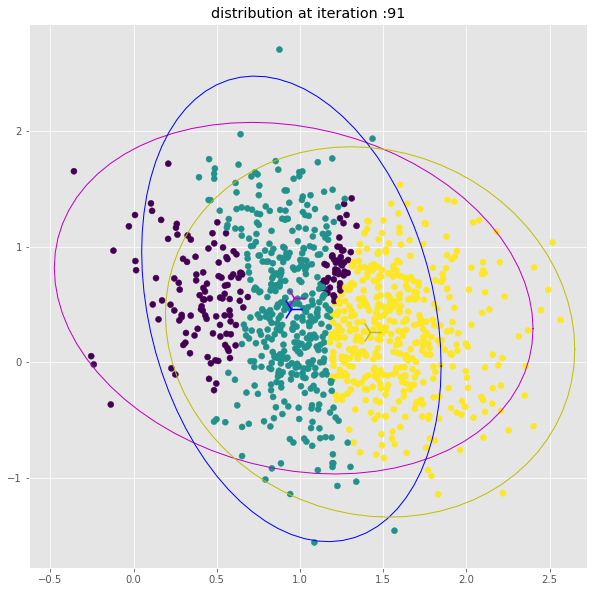

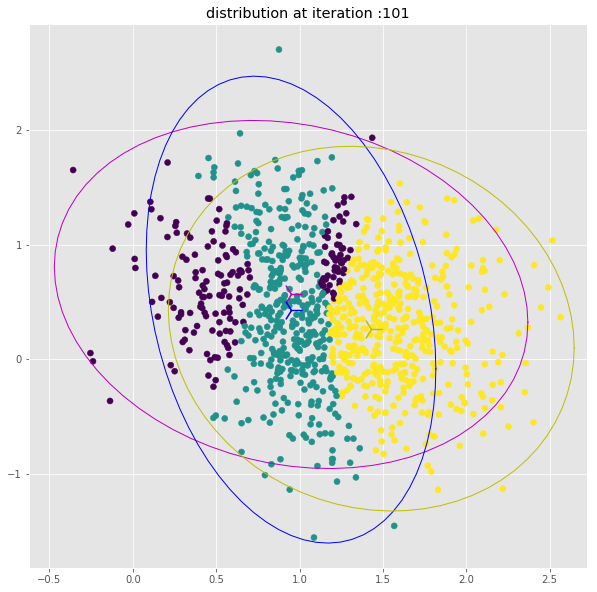

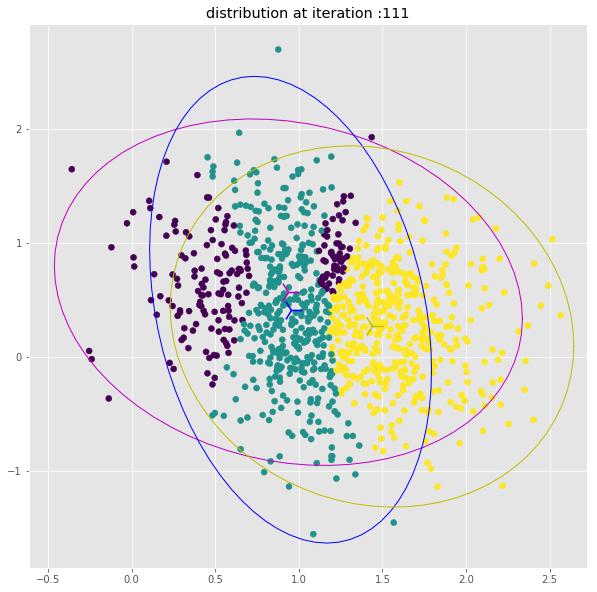

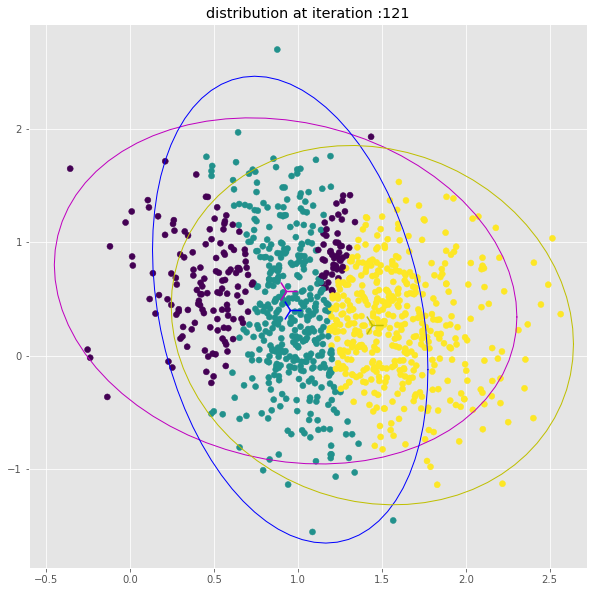

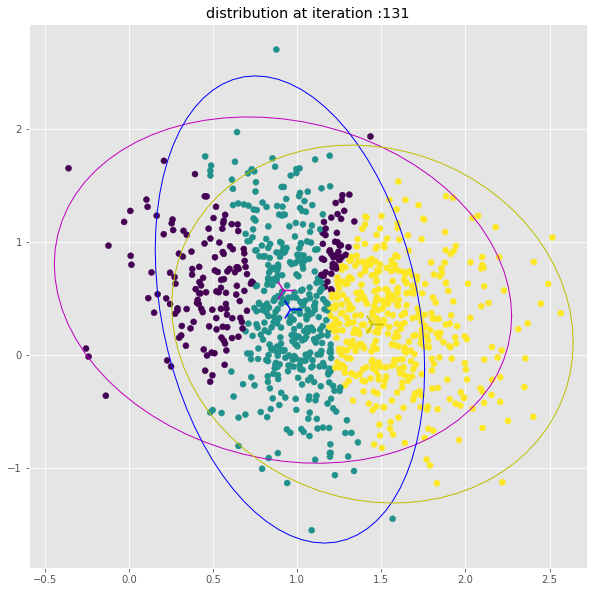

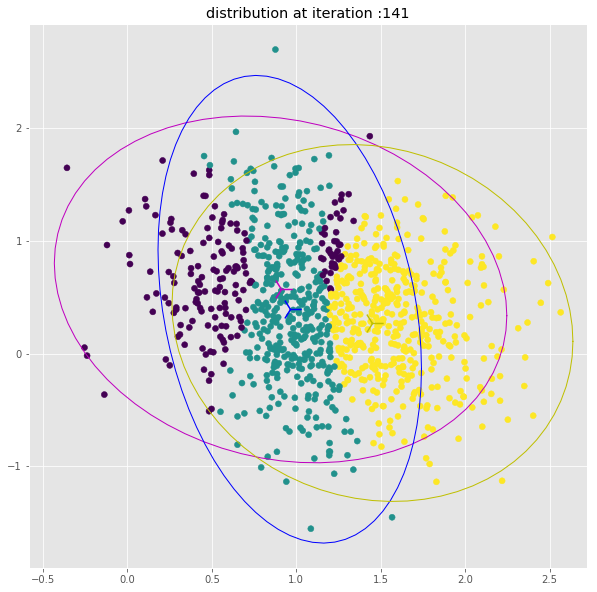

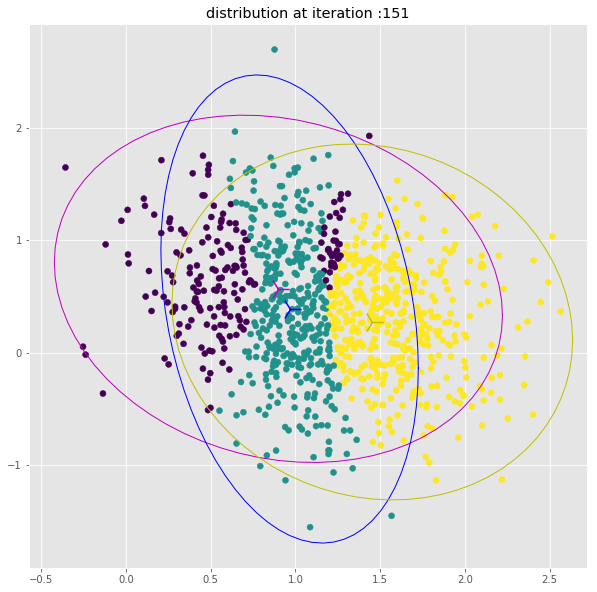

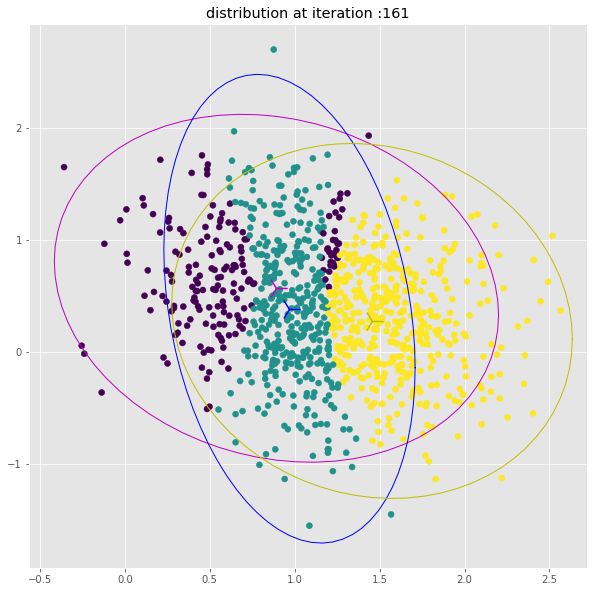

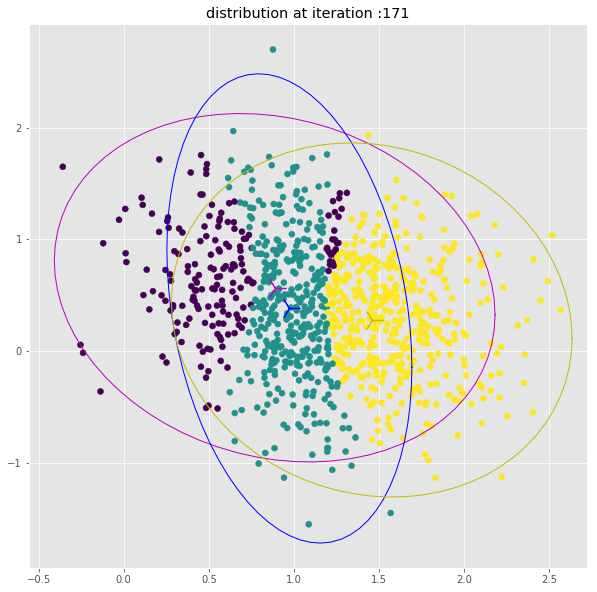

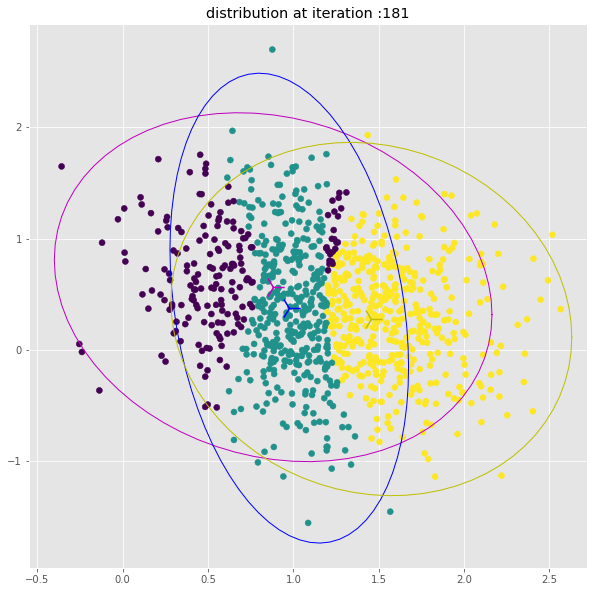

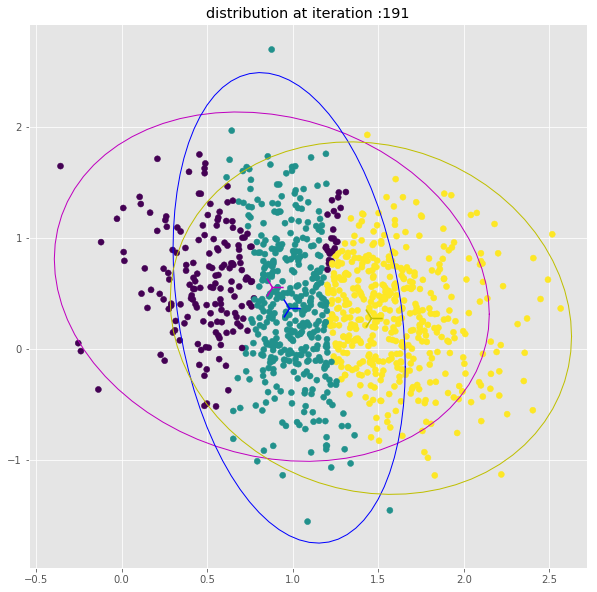

In [19]:
p_final, u_final, sigma_final,log=EM_alg(X,p_in,u_in,sigma_in,n_iter=200)

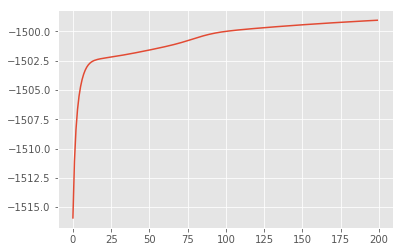

In [20]:
plt.plot(log)

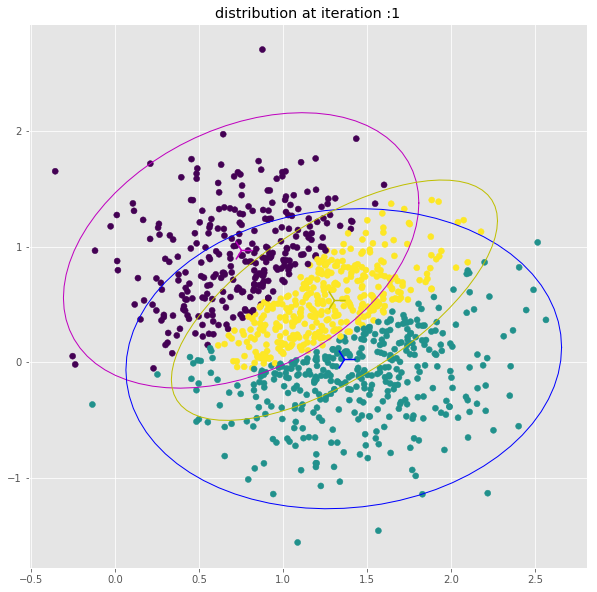

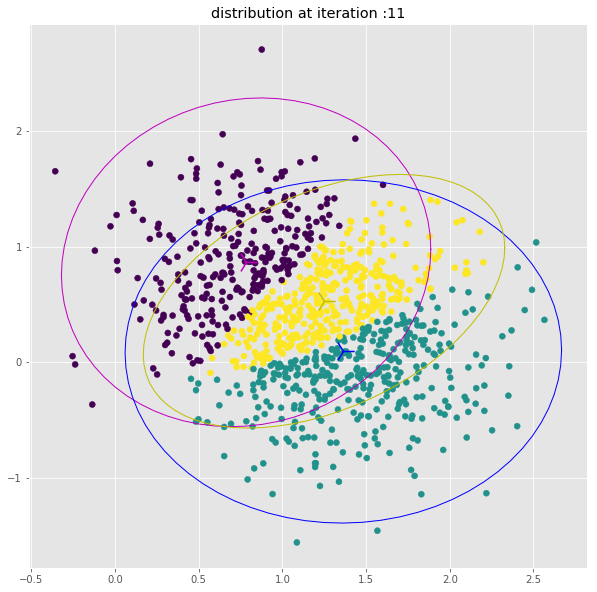

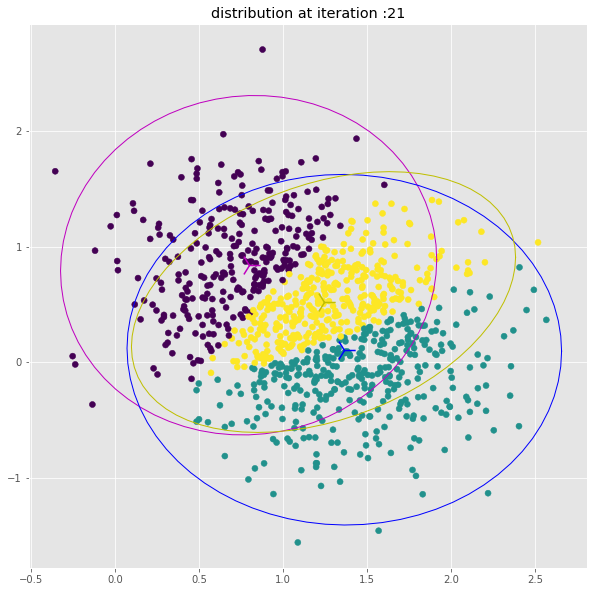

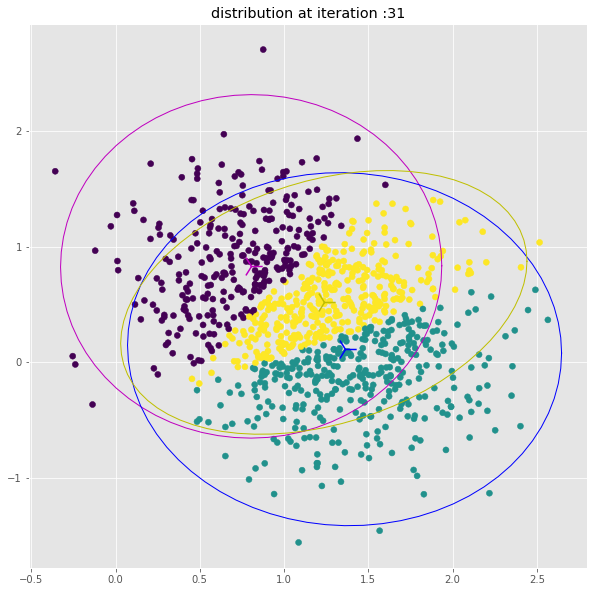

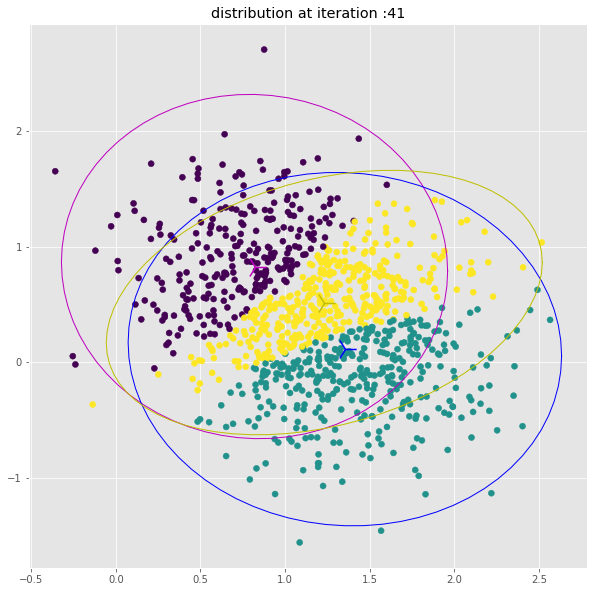

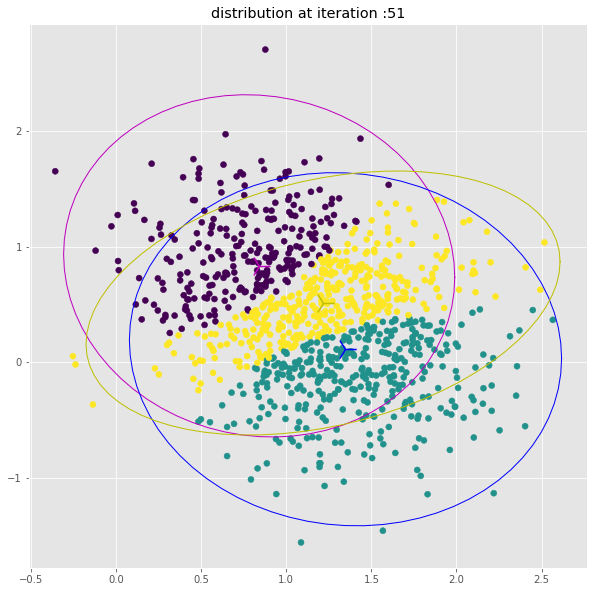

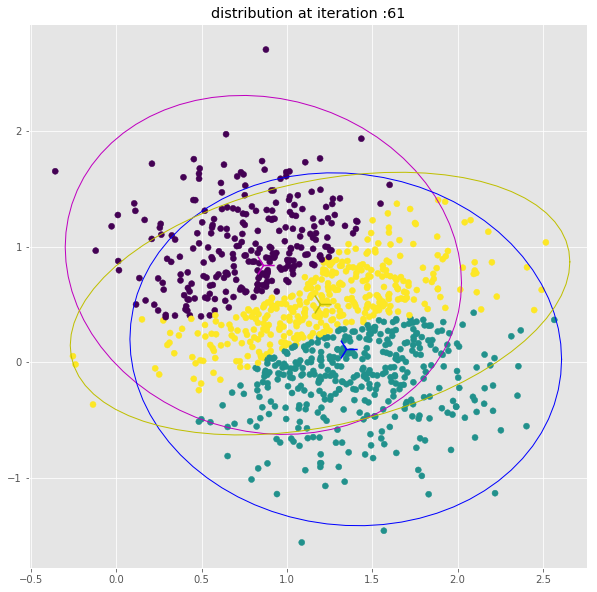

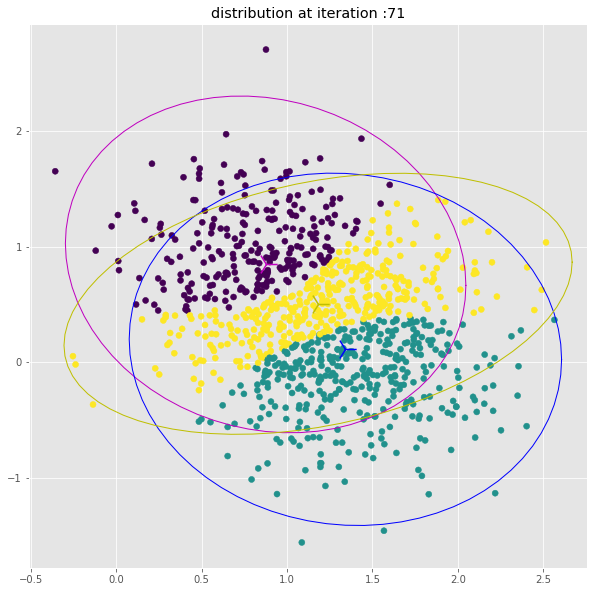

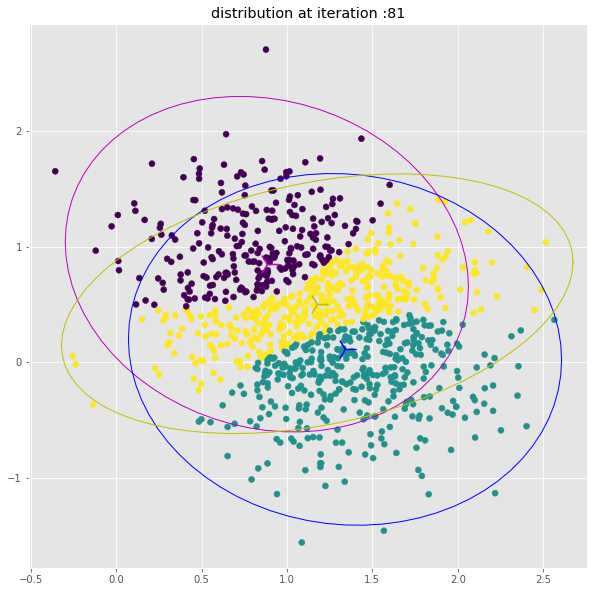

In [24]:
p_init,u_init,sigma_init=generate_matrices()
l_pi, l_mu, l_sigma,log=EM_alg(X,p_init,u_init,sigma_init,n_iter=90)

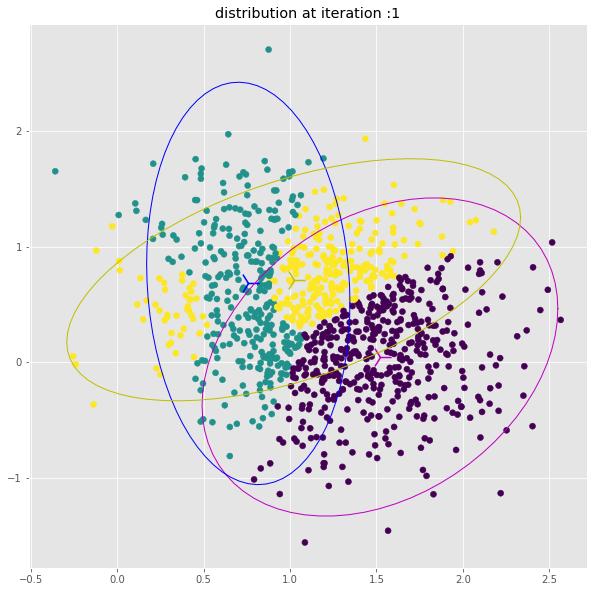

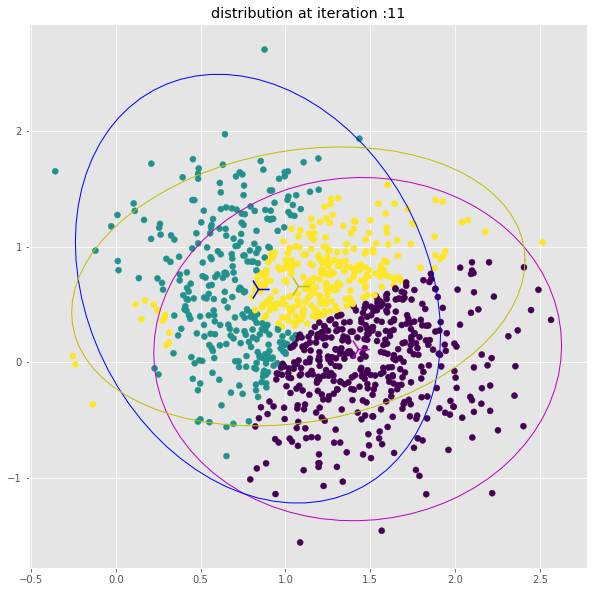

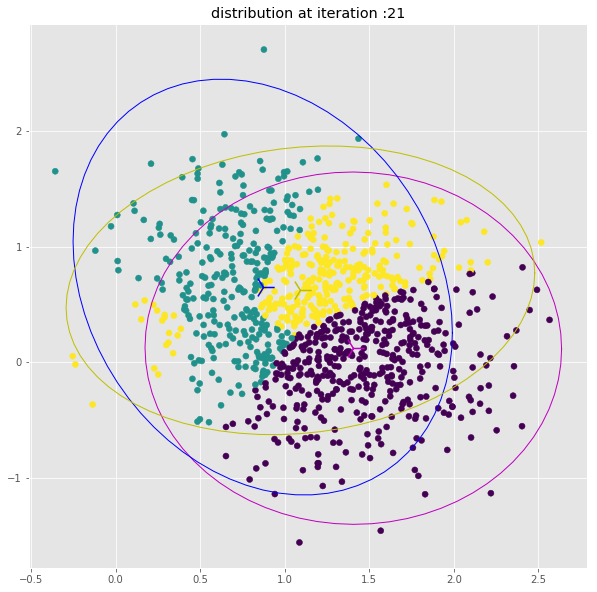

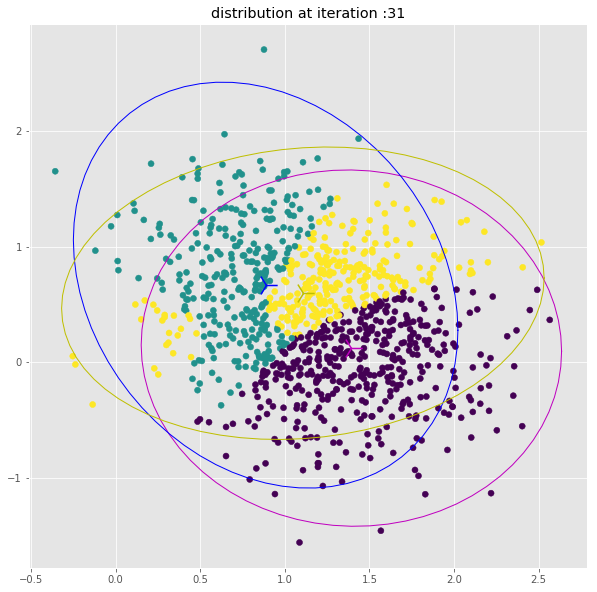

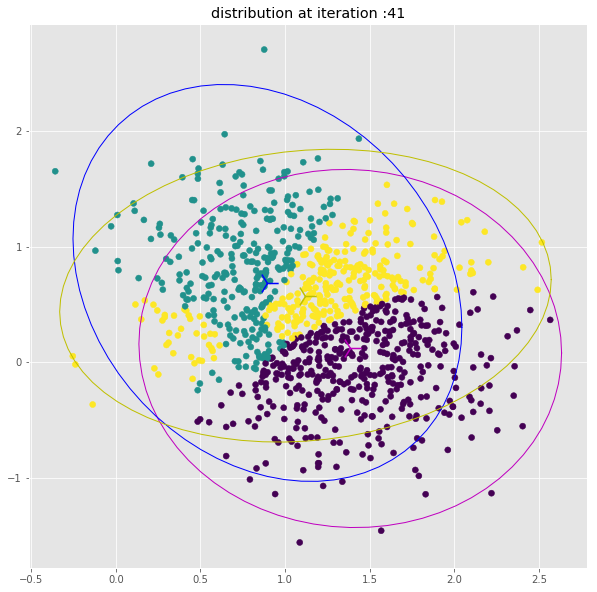

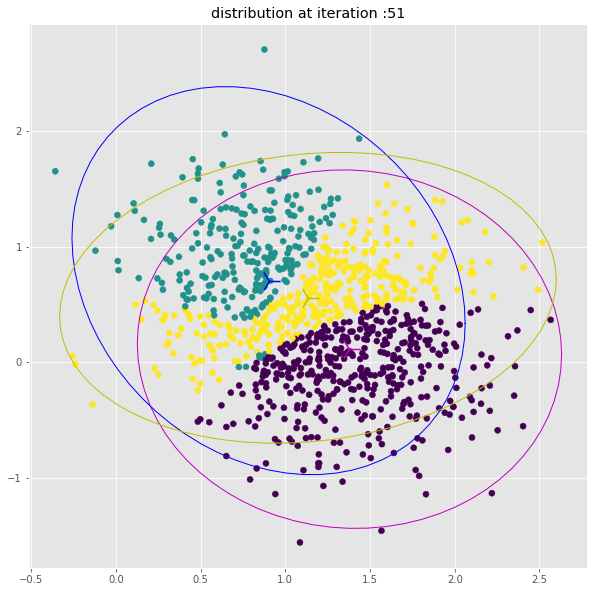

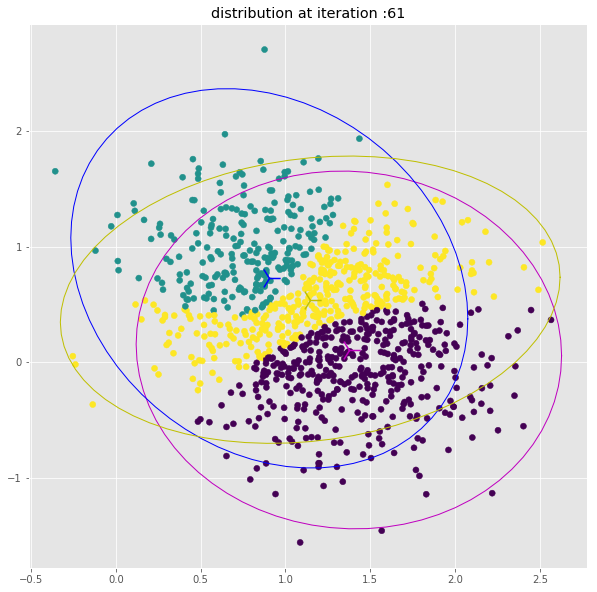

In [26]:
p_init,u_init,sigma_init=generate_matrices()
l_pi, l_mu, l_sigma,log_likelyhood=EM_alg(X,p_init,u_init,sigma_init,n_iter=70)

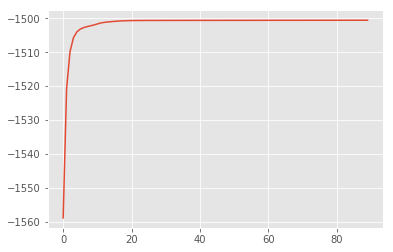

In [23]:
plt.plot(log)

<div class="alert alert-info">
<center><strong> Comment: </strong></center>
    
<br>

As we can see here, the algorithm is very sensitive to the different initial values of $\pi_{1:K}^{(0)}$ , $\mu_{1:K}^{(0)}$ and  $\Sigma_{1:K}^{(0)}$  .In fact, for each different initial values, we obtain different cluster's distribution.

<br>

We also notice that the convergence speed depand also on the intial values of $\theta$=$\pi_{1:K}^{(0)}$ , $\mu_{1:K}^{(0)}$ and  $\Sigma_{1:K}^{(0)}$